# This notebook compares the outputs from VESIcal to the excel spreadsheet provided by Allison
- This notebook relies on the Excel spreadsheet entitled: "Testing_Allison_et_al_2019.xlsx"
- Test 1 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at variable CO$_2$ contents (H$_2$O=0 wt%).
- Test 2 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at 500 ppm CO$_2$ and variable melt H$_2$O contents - CURRENT STATUS - OKAY AT LOW H2O CONTENTS
- Test 3 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at 5000 ppm CO$_2$ and variable melt H$_2$O contents - CURRENT STATUS  - FAIL
- Test 4 checks whether Allison Carbon and other models are actually sensitive to CO2. Seems not. Or is the problem that Allison Carbon isn't returning any results, so just getting the minimal effect of the H2O. 

In [1]:
import VESIcal as v
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
plt.rcParams["font.family"] = 'arial'
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
%matplotlib inline
sns.set(style="ticks", context="poster",rc={"grid.linewidth": 1,"xtick.major.width": 1,"ytick.major.width": 1, 'patch.edgecolor': 'black'})
plt.style.use("seaborn-colorblind")
#jtplot.style()
mpl.rcParams['patch.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 1 # set the value globally

# Test 1 - Saturation pressures for variable CO$_2$ contents (Sunset Crater, 0 wt% H$_2$O)
- this test compares saturation pressures from the spreadsheet of Allison et al. (2019) to those calculated by VESIcal for the Sunset Crater composition.

Text(3000, 1550, 'R$^2$= 1.0')

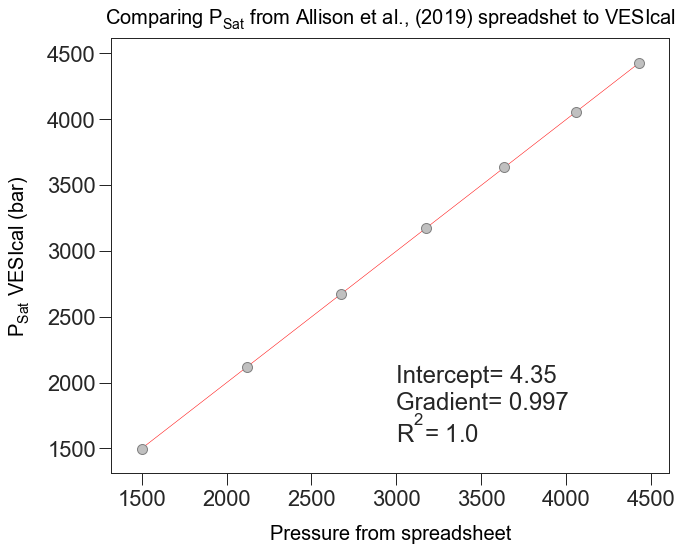

In [4]:
# Just C no H2O
myfile_Test1= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_VariableCarbon_0W')
data_Test1 = myfile_Test1.data
satPs_wtemps_Allison_Carbon_Test1=myfile_Test1.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon')
X_Test1=satPs_wtemps_Allison_Carbon_Test1['Press'] # Convert MPa from their supplement to bars
Y_Test1=satPs_wtemps_Allison_Carbon_Test1['SaturationP_bars_VESIcal']
mask_Test1 = (X_Test1>-1) & (Y_Test1>-1) #& (XComb<7000) # This gets rid of Nans
X_Test1noNan=X_Test1[mask_Test1].values.reshape(-1, 1)
Y_Test1noNan=Y_Test1[mask_Test1].values.reshape(-1, 1)
lr=LinearRegression()
lr.fit(X_Test1noNan,Y_Test1noNan)
Y_pred_Test1=lr.predict(X_Test1noNan)


fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
ax1.set_title('Comparing P$_{Sat}$ from Allison et al., (2019) spreadshet to VESIcal',
        fontdict= font, pad = 15)
plt.xlabel('Pressure from spreadsheet', fontdict=font, labelpad = 15)
plt.ylabel('P$_{Sat}$ VESIcal (bar)', fontdict=font, labelpad = 15)
plt.plot(X_Test1noNan,Y_pred_Test1, color='red', linewidth=0.5, zorder=1) # This plots the best fit line
plt.scatter(X_Test1, Y_Test1,  s=100, edgecolors='gray', facecolors='silver', marker='o', zorder=5)
# This bit plots the regression parameters on the graph
I='Intercept= ' + str(np.round(lr.intercept_, 3))[1:-1]
G='Gradient= '  + str(np.round(lr.coef_, 3))[2:-2]
R='R$^2$= '  +  str(np.round(r2_score(Y_Test1noNan, Y_pred_Test1), 6)) 

plt.text(3000, 2000, I)
plt.text(3000, 1800, G)
plt.text(3000, 1550, R)



# Test 2 - Saturation pressures for variable CO$_2$ contents (0 wt% H$_2$O) for all 5 compositions
- this test compares saturation pressures from the spreadsheet of Allison et al. (2019) to those calculated by VESIcal for all 6 compositional models (H$_2$O=0 wt%, and 100, 5000 and 10,000 ppm CO$_2$.

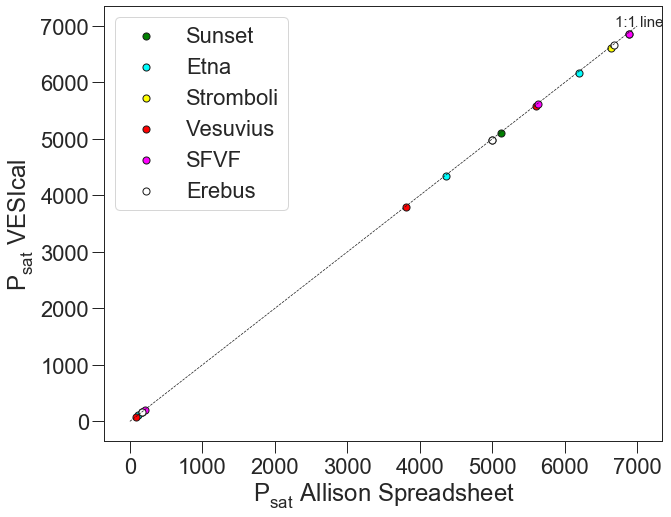

In [6]:
myfile_Test2= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='Diff_Models_VariableCarbon_0W')
data_Test2 = myfile_Test2.data
data_Test2.head()
satPs_Allison_Carbon_Test2_Sunset=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='sunset', model_fit='thermodynamic')
satPs_Allison_Carbon_Test2_SFVF=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='sfvf', model_fit='thermodynamic')
satPs_Allison_Carbon_Test2_Erebus=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='erebus', model_fit='thermodynamic')
satPs_Allison_Carbon_Test2_Vesuvius=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='vesuvius', model_fit='thermodynamic')
satPs_Allison_Carbon_Test2_Etna=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='etna', model_fit='thermodynamic')
satPs_Allison_Carbon_Test2_Stromboli=myfile_Test2.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', model_loc='stromboli', model_fit='thermodynamic')



fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
plt.plot([0, 7000], [0, 7000], zorder=1, color='k', linestyle='dashed', linewidth=0.7)
plt.scatter(satPs_Allison_Carbon_Test2_Sunset.loc[satPs_Allison_Carbon_Test2_Sunset.Location=='SunsetCrater', ['Press']], 
            satPs_Allison_Carbon_Test2_Sunset.loc[satPs_Allison_Carbon_Test2_Sunset.Location=='SunsetCrater', ['SaturationP_bars_VESIcal']], 
            s=50, label='Sunset', marker='o', facecolor='green', edgecolor='k')
plt.scatter(satPs_Allison_Carbon_Test2_Etna.loc[satPs_Allison_Carbon_Test2_Sunset.Location=='Etna', ['Press']], 
            satPs_Allison_Carbon_Test2_Etna.loc[satPs_Allison_Carbon_Test2_Sunset.Location=='Etna', ['SaturationP_bars_VESIcal']], 
            s=50, label='Etna', marker='o', facecolor='cyan', edgecolor='k')
plt.scatter(satPs_Allison_Carbon_Test2_Stromboli.loc[satPs_Allison_Carbon_Test2_Stromboli.Location=='Stromboli', ['Press']], 
            satPs_Allison_Carbon_Test2_Stromboli.loc[satPs_Allison_Carbon_Test2_Stromboli.Location=='Stromboli', ['SaturationP_bars_VESIcal']], 
            s=50, label='Stromboli', marker='o', facecolor='yellow', edgecolor='k')
plt.scatter(satPs_Allison_Carbon_Test2_Vesuvius.loc[satPs_Allison_Carbon_Test2_Vesuvius.Location=='Vesuvius', ['Press']], 
            satPs_Allison_Carbon_Test2_Vesuvius.loc[satPs_Allison_Carbon_Test2_Vesuvius.Location=='Vesuvius', ['SaturationP_bars_VESIcal']], 
            s=50, label='Vesuvius', marker='o', facecolor='red', edgecolor='k')
plt.scatter(satPs_Allison_Carbon_Test2_SFVF.loc[satPs_Allison_Carbon_Test2_SFVF.Location=='SFVF', ['Press']], 
            satPs_Allison_Carbon_Test2_SFVF.loc[satPs_Allison_Carbon_Test2_SFVF.Location=='SFVF', ['SaturationP_bars_VESIcal']], 
            s=50, label='SFVF', marker='o', facecolor='magenta', edgecolor='k')
plt.scatter(satPs_Allison_Carbon_Test2_Erebus.loc[satPs_Allison_Carbon_Test2_Erebus.Location=='Erebus', ['Press']], 
            satPs_Allison_Carbon_Test2_Erebus.loc[satPs_Allison_Carbon_Test2_SFVF.Location=='Erebus', ['SaturationP_bars_VESIcal']], 
            s=50, label='Erebus', marker='o', facecolor='white', edgecolor='k')
one='1:1 line'
plt.text(6700, 7000, one, fontsize=15)
plt.xlabel('P$_{sat}$ Allison Spreadsheet')
plt.ylabel('P$_{sat}$ VESIcal')
plt.legend()

# Test 3 - Saturation pressures for 500 ppm C, using different mixed fluid models

In [34]:
# Setting up different models
mixed_model_Moore_Allison = v.MixedFluid({'CO2':v.AllisonCarbon(),
                                         'H2O':v.MooreWater()})

mixed_model_Moore_Dixon = v.MixedFluid({'CO2':v.DixonCarbon(),
                                        'H2O':v.MooreWater()})

mixed_model_Dixon_Allison = v.MixedFluid({'CO2':v.AllisonCarbon(),
                                          'H2O':v.DixonWater()})

mixed_model_Shish_Allison = v.MixedFluid({'CO2':v.AllisonCarbon(),
                                          'H2O':v.ShishkinaWater()})

mixed_model_IM_Allison = v.MixedFluid({'CO2':v.AllisonCarbon(),
                                       'H2O':v.IaconoMarzianoWater()})

In [43]:
myfile_Test3= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_500ppm')
data_Test3 = myfile_Test3.data
#Moore
satPs_wtemps_Allison_500_Mixed_Moore=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Moore_Allison)
#Dixon
satPs_wtemps_Allison_500_Mixed_Dixon=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Dixon_Allison)
# Shishkina
satPs_wtemps_Allison_500_Mixed_Shish=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Shish_Allison)
# Iacono
satPs_wtemps_Allison_500_Mixed_Iacono=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model=mixed_model_IM_Allison)
# Testing other responses
satPs_wtemps_MooreDixon_500=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Moore_Dixon)
satPs_wtemps_Dixon_500=myfile_Test3.calculate_saturation_pressure(temperature="Temp", model='Dixon')


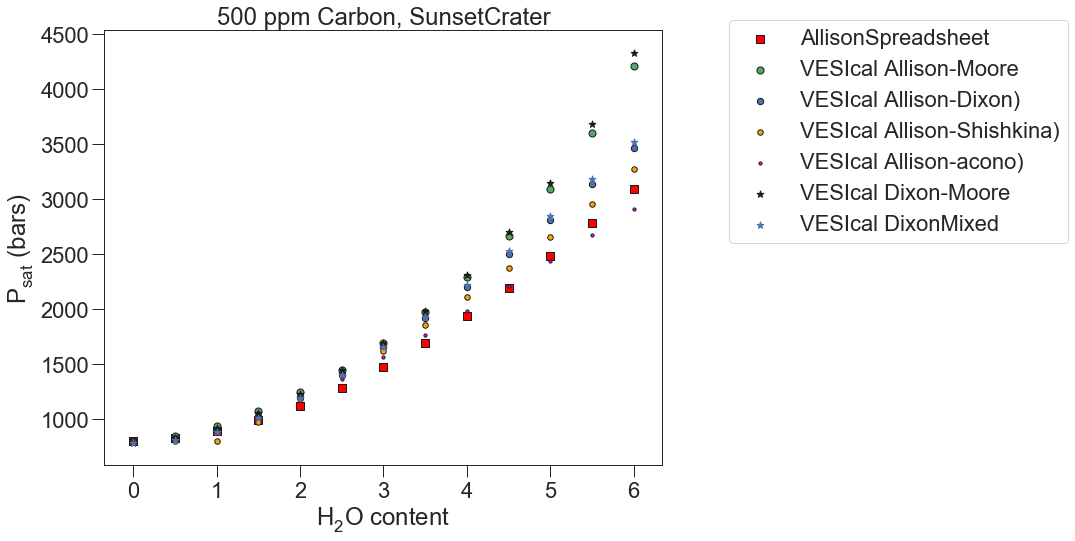

In [44]:
fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
plt.scatter(data_Test3['H2O'], data_Test3['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet')
plt.scatter(satPs_wtemps_Allison_500_Mixed_Moore['H2O'], satPs_wtemps_Allison_500_Mixed_Moore['SaturationP_bars_VESIcal'], s=50, label='VESIcal Allison-Moore', marker='o', facecolor='g', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_500_Mixed_Dixon['H2O'], satPs_wtemps_Allison_500_Mixed_Dixon['SaturationP_bars_VESIcal'], s=40,label='VESIcal Allison-Dixon)', marker='o', facecolor='b', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_500_Mixed_Shish['H2O'], satPs_wtemps_Allison_500_Mixed_Shish['SaturationP_bars_VESIcal'], s=30,label='VESIcal Allison-Shishkina)', marker='o', facecolor='orange', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_500_Mixed_Iacono['H2O'], satPs_wtemps_Allison_500_Mixed_Iacono['SaturationP_bars_VESIcal'],s=10, label='VESIcal Allison-acono)', marker='o', facecolor='magenta', edgecolor='k')
plt.scatter(satPs_wtemps_MooreDixon_500['H2O'], satPs_wtemps_MooreDixon_500['SaturationP_bars_VESIcal'],s=50, label='VESIcal Dixon-Moore', marker='*', facecolor='k', edgecolor='k')
plt.scatter(satPs_wtemps_Dixon_500['H2O'], satPs_wtemps_Dixon_500['SaturationP_bars_VESIcal'],s=50, label='VESIcal DixonMixed', marker='*', facecolor='b', edgecolor='b')


plt.legend()
plt.xlabel('H$_2$O content')
plt.ylabel('P$_{sat}$ (bars)')
plt.title('500 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

# Test 4 - same as test 3, but with 5000 ppm not 500

In [10]:
myfile_Test4= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_5000ppm')
data_Test4 = myfile_Test4.data
#Moore
satPs_wtemps_Allison_5000_Mixed_Moore=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Moore_Allison)
#Dixon
satPs_wtemps_Allison_5000_Mixed_Dixon=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Dixon_Allison)
# Shishkina
satPs_wtemps_Allison_5000_Mixed_Shish=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Shish_Allison)
# Iacono
satPs_wtemps_Allison_5000_Mixed_Iacono=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model=mixed_model_IM_Allison)
satPs_wtemps_MooreDixon_5000=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model=mixed_model_Moore_Dixon)
satPs_wtemps_Dixon_5000=myfile_Test4.calculate_saturation_pressure(temperature="Temp", model='Dixon')


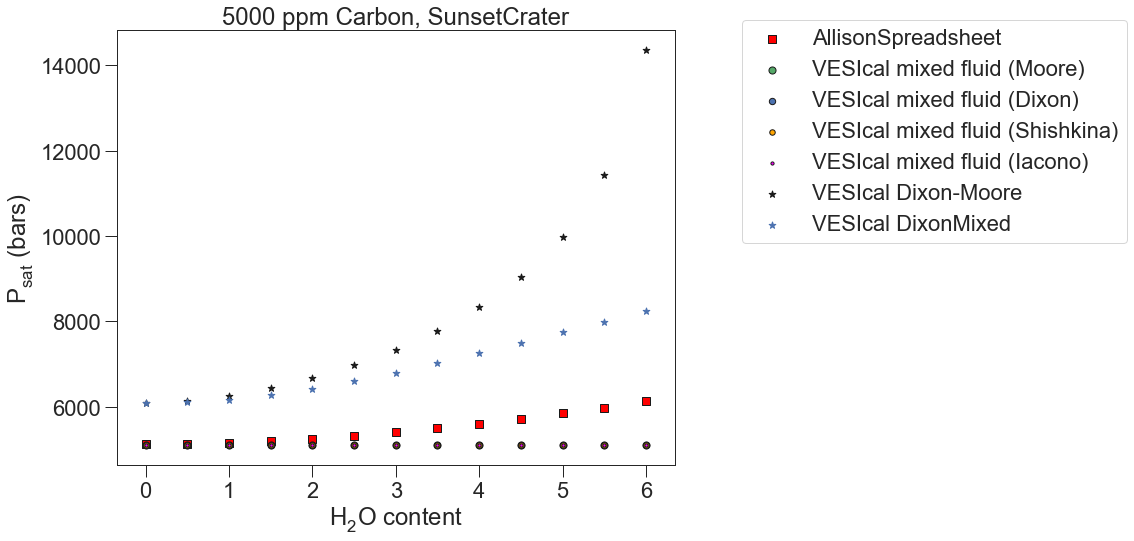

In [11]:
fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
plt.scatter(data_Test4['H2O'], data_Test4['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet')
plt.scatter(satPs_wtemps_Allison_5000_Mixed_Moore['H2O'], satPs_wtemps_Allison_5000_Mixed_Moore['SaturationP_bars_VESIcal'], s=50, label='VESIcal mixed fluid (Moore)', marker='o', facecolor='g', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_5000_Mixed_Dixon['H2O'], satPs_wtemps_Allison_5000_Mixed_Dixon['SaturationP_bars_VESIcal'], s=40,label='VESIcal mixed fluid (Dixon)', marker='o', facecolor='b', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_5000_Mixed_Shish['H2O'], satPs_wtemps_Allison_5000_Mixed_Shish['SaturationP_bars_VESIcal'], s=30,label='VESIcal mixed fluid (Shishkina)', marker='o', facecolor='orange', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_5000_Mixed_Iacono['H2O'], satPs_wtemps_Allison_5000_Mixed_Iacono['SaturationP_bars_VESIcal'],s=10, label='VESIcal mixed fluid (Iacono)', marker='o', facecolor='magenta', edgecolor='k')
plt.scatter(satPs_wtemps_MooreDixon_5000['H2O'], satPs_wtemps_MooreDixon_5000['SaturationP_bars_VESIcal'],s=50, label='VESIcal Dixon-Moore', marker='*', facecolor='k', edgecolor='k')
plt.scatter(satPs_wtemps_Dixon_5000['H2O'], satPs_wtemps_Dixon_5000['SaturationP_bars_VESIcal'],s=50, label='VESIcal DixonMixed', marker='*', facecolor='b', edgecolor='b')

plt.legend()
plt.xlabel('H$_2$O content')
plt.ylabel('P$_{sat}$ (bars)')
plt.title('5000 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

In [49]:
sample = {'SiO2': 47.3,
          'TiO2': 2.35,
          'Al2O3': 14.17,
          'FeO': 10.82,
          'MnO': 0.17,
          'MgO': 10.36,
          'CaO': 9.94,
          'Na2O': 3.52,
          'K2O': 0.83,
          'P2O5': 0.47,
          'Cr2O3': 0.06,
#           'CO2': 500*1e-4,
#           'H2O': 2.0
         }

# mixed_model_Dixon_Allison.calculate_saturation_pressure(sample=sample,temperature=1200)
ib, ip = mixed_model_Dixon_Allison.calculate_isobars_and_isopleths([500.0,1000.0,2000.0],[0,0.2,0.4,0.6,0.8,1.0],temperature=1200,sample=sample)
ibs, ips = mixed_model_Dixon_Allison.calculate_isobars_and_isopleths([500.0,1000.0,2000.0],[0,0.2,0.4,0.6,0.8,1.0],temperature=1200,sample=sample,model_loc='sfvf')
ibe, ipe = mixed_model_Dixon_Allison.calculate_isobars_and_isopleths([500.0,1000.0,2000.0],[0,0.2,0.4,0.6,0.8,1.0],temperature=1200,sample=sample,model_loc='erebus')
ibv, ipv = mixed_model_Dixon_Allison.calculate_isobars_and_isopleths([500.0,1000.0,2000.0],[0,0.2,0.4,0.6,0.8,1.0],temperature=1200,sample=sample,model_loc='vesuvius')
ibt, ipt = mixed_model_Dixon_Allison.calculate_isobars_and_isopleths([500.0,1000.0,2000.0],[0,0.2,0.4,0.6,0.8,1.0],temperature=1200,sample=sample,model_loc='stromboli')

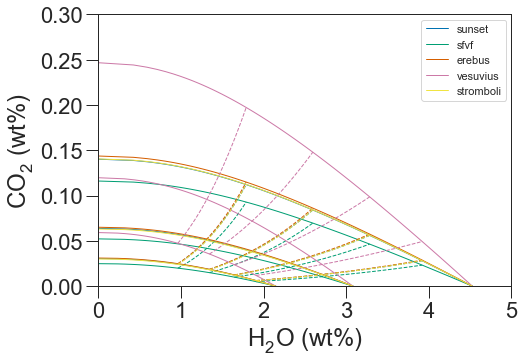

In [57]:
f,a = plt.subplots(figsize=[7.4,5.0])
ibfs = [ib,ibs,ibe,ibv,ibt]
ipfs = [ip,ips,ipe,ipv,ipt]
names = ['sunset','sfvf','erebus','vesuvius','stromboli']
for i,ibf, ipf, name in zip(range(len(names)),ibfs,ipfs,names):
    a.plot([-1,-1],[-1,-1],c='C'+str(i),lw=1,label=name)
    for p in ibf.Pressure.unique():
        a.plot(ibf[ibf.Pressure==p].H2O_liq,ibf[ibf.Pressure==p].CO2_liq,c='C'+str(i),lw=1)
    for x in ip.XH2O_fl.unique():
        a.plot(ipf[ipf.XH2O_fl==x].H2O_liq,ipf[ipf.XH2O_fl==x].CO2_liq,c='C'+str(i),ls='--',lw=1)
a.set_xlim(0,5)
a.set_ylim(0,0.3)
a.legend(fontsize=11)
a.set_xlabel(r'H$_2$O (wt%)')
a.set_ylabel(r'CO$_2$ (wt%)')
plt.show()